In [135]:
import glob, os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from pyomo.environ import *
import scipy.stats as st
import scipy

data = pd.read_csv('/Users/yul/Google 드라이브/USC/2019 Spring/ISE533 Projects/3. LEO-Wyndsor/Advertising.csv')
data = data.drop([data.columns[0] , data.columns[3]],  axis=1)
data.reset_index
data.head(3)

,TV,Radio,Sales
0,230.1,37.8,26.52
1,44.5,39.3,12.48
2,17.2,45.9,11.16


In [197]:
# Skip this part
X = data[['TV','Radio']]
Y = data[['Sales']]

np.random.seed(1)
X_t, X_v, Y_t, Y_v = train_test_split(X, Y, test_size=0.5)
print (X_t.shape, Y_t.shape)
print (X_v.shape, Y_v.shape)

(100, 2) (100, 1)
(100, 2) (100, 1)


In [198]:
# X_t = X[:100]
# X_v = X[100:200]
# Y_t = Y[:100]
# Y_v = Y[100:200]

In [199]:
regr = linear_model.LinearRegression()
regr.fit(X_t, Y_t)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [3.74982951]
Coefficients: 
 [[0.05370186 0.22231025]]


In [201]:
t_epsilon = regr.predict(X_t) - Y_t
t_epsilon = t_epsilon['Sales'].to_list()

t_epsilon = [round(x,4) for x in t_epsilon]
# t_epsilon

size = 10
g = (t_epsilon[i:i+size] for i in range(0, len(t_epsilon), size))
for i in g:
    print(i)

[3.9323, 2.6324, -3.1408, -0.3789, 3.7175, -0.7154, -0.0245, 2.5941, -0.0305, -0.3112]
[-2.01, 2.7088, -0.4833, -1.6373, -3.0267, 1.3714, -1.3194, 10.6709, -1.9522, 1.2065]
[0.2786, -0.3919, -2.7767, -0.2428, -1.8458, -0.4796, 0.1375, -0.6534, -0.9684, -1.7311]
[-2.2169, 0.9958, -2.405, 2.6091, -1.6641, 1.167, 4.8966, 2.3375, -1.0663, -0.6731]
[-1.8048, 2.8722, -0.9826, 3.1187, -1.295, -2.0326, 0.1602, -0.8889, -0.3146, -0.3717]
[-2.4787, -0.0625, -2.6977, 1.2482, -1.7434, -1.1329, 3.3738, -1.6965, -0.2341, 3.3963]
[2.048, 0.0905, 1.1836, 0.4437, -2.9092, -1.0815, -2.6525, -3.1664, 2.3964, -0.5076]
[1.2734, -1.7652, -0.9546, -1.2779, -1.7421, -1.0183, -0.4392, 1.0994, -0.0678, 1.4886]
[-1.1482, -0.0366, 0.1029, -1.4013, 2.4265, -0.8231, 0.0363, 4.9604, 4.2461, 1.3526]
[-2.0547, -2.0218, -1.4739, -1.495, -1.509, -0.5191, -0.0872, 1.9653, -1.6092, 1.1035]


In [202]:
v_epsilon = regr.predict(X_v) - Y_v
v_epsilon = v_epsilon['Sales'].to_list()
# v_epsilon = v_epsilon.to_list()
v_epsilon = [round(x,4) for x in v_epsilon]

size = 10
g = (v_epsilon[i:i+size] for i in range(0, len(v_epsilon), size))
for i in g:
    print(i)

[-2.4632, -0.338, -2.1997, 3.2824, 0.9946, -2.2833, -0.7357, 0.3801, -1.5019, 0.0437]
[-0.1699, -1.5366, -0.2649, 0.2327, 1.6187, -0.3766, -0.5671, 4.9124, 2.3947, -0.457]
[-1.5643, 0.5274, 0.6111, -1.1702, -0.599, 0.0111, -0.1199, 0.4555, -1.4757, 1.2762]
[-1.9812, 2.8188, -1.0568, 0.5839, -0.4369, -0.2522, 2.649, -1.234, -1.6082, 0.1508]
[-1.8178, -1.7688, -0.596, -0.7756, 3.7888, -0.5467, 0.8334, -1.425, -2.3351, -0.385]
[-1.769, -0.1875, 0.4286, -1.6135, 1.5792, -0.254, 2.0442, -1.1022, 2.0459, 0.2968]
[-0.2358, -1.626, 4.3269, 0.8347, -1.615, 6.448, -2.5033, -1.5695, 1.7034, -0.4897]
[0.0198, -1.2655, -2.6862, 3.8214, 3.47, 0.5053, 1.791, -3.2495, -1.302, -1.3042]
[-0.1942, -1.3887, 2.779, 2.3926, -1.6747, -0.9647, -1.2535, 3.4078, -0.3674, 0.275]
[-0.3593, -2.66, 0.3508, -0.6519, -1.0253, 0.0241, -2.4962, -0.0375, 1.6696, 0.3316]


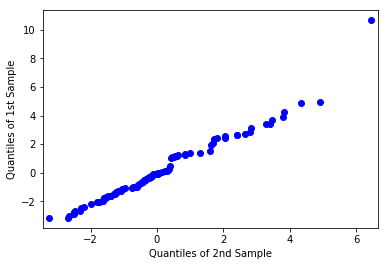

In [203]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

norm_t_epsilon = [number-np.mean(t_epsilon)/scipy.std(t_epsilon) for number in t_epsilon]
# norm_t_epsilon = norm_t_epsilon.sort()
norm_v_epsilon = [number-np.mean(v_epsilon)/scipy.std(v_epsilon) for number in v_epsilon]
# norm_v_epsilon = norm_v_epsilon.sort()

qq1 = sorted(norm_t_epsilon)
qq2 = sorted(norm_v_epsilon)

dfqq1 = pd.DataFrame(qq1)
dfqq2 = pd.DataFrame(qq2)

sm.qqplot_2samples(dfqq1,dfqq2)
plt.show()

In [204]:
def outliers(a): 
    minpos = a.index(min(a)) 
    maxpos = a.index(max(a))   
    print("The maximum is at position", maxpos)
    print("The minimum is at position", minpos)
outliers(t_epsilon)

The maximum is at position 17
The minimum is at position 67


In [205]:
X_t.iloc[17]

TV        0.7
Radio    39.6
Name: 130, dtype: float64

In [206]:
X_t.iloc[67]

TV       220.3
Radio     49.0
Name: 128, dtype: float64

In [207]:
X_t = X_t.drop(X_t.index[[17,67]])
Y_t = Y_t.drop(Y_t.index[[17,67]])
len(X_t)

98

In [208]:
lm = linear_model.LinearRegression()
lm.fit(X_t, Y_t)

print('Intercept: \n', lm.intercept_)
print('Coefficients: \n', lm.coef_)

Intercept: 
 [4.07459792]
Coefficients: 
 [[0.05119161 0.22734845]]


In [209]:
beta0 = regr.intercept_.tolist()[0] ; beta1 = regr.coef_.tolist()[0][0] ; beta2 = regr.coef_.tolist()[0][1]

In [210]:
print("Kruskal Wallis H-test test:")

H, pval = st.mstats.kruskalwallis(norm_t_epsilon,norm_v_epsilon)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 0.2942328358209352
P-Value: 0.587520710848539
Accept NULL hypothesis - No significant difference between groups.


### 1. Deterministic LP 

In [211]:
# Create the model
dm = ConcreteModel()
opt = SolverFactory('gurobi_ampl')
dm.dual = Suffix(direction=Suffix.IMPORT)

# Define decision Variables
X = ['x1','x2']; Y = ['ya','yb']

dm.x = Var(X,domain=NonNegativeReals)
dm.y = Var(Y,domain=NonNegativeReals)

# Define Objective
dm.obj = Objective(expr = -0.1 * dm.x['x1'] -0.5 * dm.x['x2']+ 3 * dm.y['ya'] + 5 * dm.y['yb'], sense=maximize)
# Define Constraints
dm.c11 = Constraint(expr = dm.y['ya'] <= 4)
dm.c12 = Constraint(expr = 2 * dm.y['yb'] <= 12)
dm.c13 = Constraint(expr = 3 * dm.y['ya'] + 2 * dm.y['yb'] <= 18)
dm.c14 = Constraint(expr = dm.y['ya'] + dm.y['yb'] - beta1 * dm.x['x1'] - beta2 * dm.x['x2']  
                   <= beta0)
dm.c21 = Constraint(expr = dm.x['x1'] + dm.x['x2'] <= 200)
dm.c22 = Constraint(expr = dm.x['x1'] - 0.5 * dm.x['x2'] >= 0)

dm.c31 = Constraint(expr = dm.x['x1'] >= min(X_t['TV'].to_list()))
dm.c32 = Constraint(expr = dm.x['x1'] <= max(X_t['TV'].to_list()))
dm.c33 = Constraint(expr = dm.x['x2'] >= min(X_t['Radio'].to_list()))
dm.c34 = Constraint(expr = dm.x['x2'] <= max(X_t['Radio'].to_list()))

results = opt.solve(dm, tee=True)
dm.display()
# print(results)

Academic license - for non-commercial use only
Gurobi 8.1.0Model unknown

  Variables:
    x : Size=2, Index=x_index
        Key : Lower : Value             : Upper : Fixed : Stale : Domain
         x1 :     0 : 73.76219156924427 :  None : False : False : NonNegativeReals
         x2 :     0 :               1.3 :  None : False : False : NonNegativeReals
    y : Size=2, Index=y_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         ya :     0 :   2.0 :  None : False : False : NonNegativeReals
         yb :     0 :   6.0 :  None : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 27.973780843075573

  Constraints:
    c11 : Size=1
        Key  : Lower : Body : Upper
        None :  None :  2.0 :   4.0
    c12 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 12.0 :  12.0
    c13 : Size=1
        Key  : Lower : Body : Upper
        None :  None : 18.0 :  18.

In [212]:
dm.obj.expr()

27.973780843075573

In [213]:
d_validation_list = []

x1 = value(dm.x['x1']) 
x2 = value(dm.x['x2'])

for i in range(len(v_epsilon)):
    # Create the model
    dm = ConcreteModel()
    opt = SolverFactory('gurobi_ampl')
    dm.dual = Suffix(direction=Suffix.IMPORT)

    # Define decision Variables
#     X = ['x1','x2']
    Y = ['ya','yb']

#     dm.x = Var(X,domain=NonNegativeReals)
    dm.y = Var(Y,domain=NonNegativeReals)

    # Define Objective
    dm.obj = Objective(expr = -0.1 * x1 -0.5 * x2 + 3 * dm.y['ya'] + 5 * dm.y['yb'], sense=maximize)
    # Define Constraints
    dm.c11 = Constraint(expr = dm.y['ya'] <= 4)
    dm.c12 = Constraint(expr = 2 * dm.y['yb'] <= 12)
    dm.c13 = Constraint(expr = 3 * dm.y['ya'] + 2 * dm.y['yb'] <= 18)
    dm.c14 = Constraint(expr = dm.y['ya'] + dm.y['yb'] - beta1 * x1 - beta2 * x2  
                       <= beta0+v_epsilon[i])
#     dm.c21 = Constraint(expr = dm.x['x1'] + dm.x['x2'] <= 200)
#     dm.c22 = Constraint(expr = dm.x['x1'] - 0.5 * dm.x['x2'] >= 0)

#     dm.c31 = Constraint(expr = dm.x['x1'] >= min(X_t['TV'].to_list()))
#     dm.c32 = Constraint(expr = dm.x['x1'] <= max(X_t['TV'].to_list()))
#     dm.c33 = Constraint(expr = dm.x['x2'] >= min(X_t['Radio'].to_list()))
#     dm.c34 = Constraint(expr = dm.x['x2'] <= max(X_t['Radio'].to_list()))

    results = opt.solve(dm)
    d_validation_list.append(dm.obj.expr())

In [214]:
d_validation_list[:5]

[19.65778084307557,
 26.959780843075574,
 20.975280843075574,
 27.973780843075573,
 27.973780843075573]

In [11]:
d_ci = st.t.interval(0.95, len(d_validation_list)-1, loc=np.mean(d_validation_list),
              scale=st.sem(d_validation_list))
print(d_ci)

(25.76996633045807, 26.52975396713818)


### 2. SP with Empirical Additive Errors

In [215]:
# ad: Annotated with location of stochastic rhs entries
#       for use with pysp2smps conversion tool.

import itertools
import random

from pyomo.core import *
from pyomo.pysp.annotations import (PySP_ConstraintStageAnnotation,
                                    PySP_StochasticRHSAnnotation)
# Define the probability table for the stochastic parameters
i=0
d1_rhs_table=t_epsilon

num_scenarios = len(d1_rhs_table)
scenario_data = dict(('Scenario'+str(i), (d1val))
                      for i, (d1val) in
                     enumerate(d1_rhs_table, 1))

model = ConcreteModel()

model.constraint_stage = PySP_ConstraintStageAnnotation()
model.stoch_rhs = PySP_StochasticRHSAnnotation()

# use mutable parameters so that the right-hand-side can be updated for each scenario
model.d1_rhs = Param(mutable=True, initialize=0.0)

# first-stage variables
model.x1 = Var(bounds=(0.7,296.4))
model.x2 = Var(bounds=(1.3,49.4))

# second-stage variables
model.y1 = Var(within=NonNegativeReals)
model.y2 = Var(within=NonNegativeReals)


# stage-cost expressions
model.FirstStageCost = \
    Expression(initialize=(0.1*model.x1+0.5*model.x2))
model.SecondStageCost = \
    Expression(initialize=(-3*model.y1-5*model.y2))

model.s1 = Constraint(expr= model.x1 - 0.5*model.x2 >= 0)
model.constraint_stage.declare(model.s1, 1)

model.s2 = Constraint(expr= model.x1 + model.x2 <= 200)
model.constraint_stage.declare(model.s2, 1)

model.s4 = Constraint(expr= model.y1 <= 4)
model.constraint_stage.declare(model.s4, 2)

model.s5 = Constraint(expr= 2*model.y2 <=12)
model.constraint_stage.declare(model.s5, 2)

model.s6 = Constraint(expr= 3*model.y1 + 2*model.y2 <= 18)
model.constraint_stage.declare(model.s6, 2)

# one constraint with stochastic right-hand-sides
model.d1 = Constraint(expr = beta0 + beta1*model.x1\
                      + beta2*model.x2 - model.y1 - model.y2 >=model.d1_rhs)
model.constraint_stage.declare(model.d1, 2)
model.stoch_rhs.declare(model.d1)


model.obj = Objective(expr=model.FirstStageCost + model.SecondStageCost)

def pysp_scenario_tree_model_callback():
    from pyomo.pysp.scenariotree.tree_structure_model import \
        CreateConcreteTwoStageScenarioTreeModel

    st_model = CreateConcreteTwoStageScenarioTreeModel(num_scenarios)

    first_stage = st_model.Stages.first()
    second_stage = st_model.Stages.last()

    # First Stage
    st_model.StageCost[first_stage] = 'FirstStageCost'
    st_model.StageVariables[first_stage].add('x1')
    st_model.StageVariables[first_stage].add('x2')

    # Second Stage
    st_model.StageCost[second_stage] = 'SecondStageCost'
    st_model.StageVariables[second_stage].add('y1')
    st_model.StageVariables[second_stage].add('y2')

    return st_model

def pysp_instance_creation_callback(scenario_name, node_names):

    #
    # Clone a new instance and update the stochastic
    # parameters from the sampled scenario
    #
    instance = model.clone()

    d1_rhs_val = scenario_data[scenario_name]
    instance.d1_rhs.value = d1_rhs_val

    return instance

    (constraint stages are automatically inferred). It will be removed in the
    future. Please update your model file.
    'StochasticConstraintBoundsAnnotation'. Please update your model file.


In [14]:
!python -m pyomo.pysp.convert.smps -m /Users/yul/Desktop/EAEmodel.py --basename EAE \--output-directory /Users/yul/Desktop/EAE --symbolic-solver-labels

/anaconda3/envs/yulenv/lib/python3.6/runpy.py:125: RuntimeWarning: 'pyomo.pysp.convert.smps' found in sys.modules after import of package 'pyomo.pysp.convert', but prior to execution of 'pyomo.pysp.convert.smps'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
ERROR: Failed to extract reference model python file from path specification:
    /Users/yul/Desktop/EAEmodel.py
pyomo.pysp.convert.smps: IO ERROR:
path does not exist: /Users/yul/Desktop/EAEmodel.py

To obtain further information regarding the source of the exception, use the --traceback option


> The objective is 22.525 <br/>  x1 = 1.288795e+02 <br/>  x2 = 0

#### 2-1. Train data Validate

In [216]:
s1_validation_list = []

x1 = 1.288795e+02 
x2 = 0

for i in range(len(t_epsilon)):
    # Create the model
    dm = ConcreteModel()
    opt = SolverFactory('gurobi_ampl')
    dm.dual = Suffix(direction=Suffix.IMPORT)

    # Define decision Variables
#     X = ['x1','x2']
    Y = ['ya','yb']

#     dm.x = Var(X,domain=NonNegativeReals)
    dm.y = Var(Y,domain=NonNegativeReals)

    # Define Objective
    dm.obj = Objective(expr = -0.1 * x1 -0.5 * x2 + 3 * dm.y['ya'] + 5 * dm.y['yb'], sense=maximize)
    # Define Constraints
    dm.c11 = Constraint(expr = dm.y['ya'] <= 4)
    dm.c12 = Constraint(expr = 2 * dm.y['yb'] <= 12)
    dm.c13 = Constraint(expr = 3 * dm.y['ya'] + 2 * dm.y['yb'] <= 18)
    dm.c14 = Constraint(expr = dm.y['ya'] + dm.y['yb'] - beta1 * x1 - beta2 * x2  
                       <= beta0+t_epsilon[i])
#     dm.c21 = Constraint(expr = dm.x['x1'] + dm.x['x2'] <= 200)
#     dm.c22 = Constraint(expr = dm.x['x1'] - 0.5 * dm.x['x2'] >= 0)

#     dm.c31 = Constraint(expr = dm.x['x1'] >= min(X_t['TV'].to_list()))
#     dm.c32 = Constraint(expr = dm.x['x1'] <= max(X_t['TV'].to_list()))
#     dm.c33 = Constraint(expr = dm.x['x2'] >= min(X_t['Radio'].to_list()))
#     dm.c34 = Constraint(expr = dm.x['x2'] <= max(X_t['Radio'].to_list()))

    results = opt.solve(dm)
    s1_validation_list.append(dm.obj.expr())

#### 2-2 Validation data validate

In [217]:
s2_validation_list = []

x1 = 1.288795e+02 
x2 = 0

for i in range(len(v_epsilon)):
    # Create the model
    dm = ConcreteModel()
    opt = SolverFactory('gurobi_ampl')
    dm.dual = Suffix(direction=Suffix.IMPORT)

    # Define decision Variables
#     X = ['x1','x2']
    Y = ['ya','yb']

#     dm.x = Var(X,domain=NonNegativeReals)
    dm.y = Var(Y,domain=NonNegativeReals)

    # Define Objective
    dm.obj = Objective(expr = -0.1 * x1 -0.5 * x2 + 3 * dm.y['ya'] + 5 * dm.y['yb'], sense=maximize)
    # Define Constraints
    dm.c11 = Constraint(expr = dm.y['ya'] <= 4)
    dm.c12 = Constraint(expr = 2 * dm.y['yb'] <= 12)
    dm.c13 = Constraint(expr = 3 * dm.y['ya'] + 2 * dm.y['yb'] <= 18)
    dm.c14 = Constraint(expr = dm.y['ya'] + dm.y['yb'] - beta1 * x1 - beta2 * x2  
                       <= beta0+v_epsilon[i])
#     dm.c21 = Constraint(expr = dm.x['x1'] + dm.x['x2'] <= 200)
#     dm.c22 = Constraint(expr = dm.x['x1'] - 0.5 * dm.x['x2'] >= 0)

#     dm.c31 = Constraint(expr = dm.x['x1'] >= min(X_t['TV'].to_list()))
#     dm.c32 = Constraint(expr = dm.x['x1'] <= max(X_t['TV'].to_list()))
#     dm.c33 = Constraint(expr = dm.x['x2'] >= min(X_t['Radio'].to_list()))
#     dm.c34 = Constraint(expr = dm.x['x2'] <= max(X_t['Radio'].to_list()))

    results = opt.solve(dm)
    s2_validation_list.append(dm.obj.expr())

In [218]:
print("Kruskal Wallis H-test test:")

H, pval = st.mstats.kruskalwallis(s1_validation_list,s2_validation_list)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

Kruskal Wallis H-test test:
H-statistic: 2.071783659978146
P-Value: 0.1500459493660963
Accept NULL hypothesis - No significant difference between groups.
